## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import cv2
from tensorflow.keras import layers, initializers, applications
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


## Turn on GPU

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*10)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1Metal device set to: Apple M1 Pro
 Physical GPUs, 1 Logical GPUs


2022-08-22 20:12:54.852439: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-22 20:12:54.852755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
def label_encoder(mask_dataset):
    labelencoder = LabelEncoder()
    n, h, w = mask_dataset.shape  
    mask_dataset_reshaped = mask_dataset.reshape(-1,1)
    mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
    mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)
    
    return mask_dataset_encoded

def categorical(y_train, n_classes):
    train_masks_cat = to_categorical(y_train, num_classes=n_classes)
    y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
    
    return y_train_cat


def read_tile(path_X, path_y, size=(256, 256)):
    sorted_X = sorted(os.listdir(path_X), key = str)
    sorted_y = sorted(os.listdir(path_y), key = str)
    length = len(sorted_X)
    
    items_X = [os.path.join(path_X, sorted_X[i]) for i in range(length)]
    items_y = [os.path.join(path_y, sorted_y[i]) for i in range(length)]

    X = np.array([cv2.imread(items_X[i], 1)[:size[0], :size[1]] for i in range(length)])
    y = np.array([cv2.imread(items_y[i], 0)[:size[0], :size[1]] for i in range(length)])

    y = label_encoder(y)
    
    return X, y
    
    
def read_data(main_path, image_path, mask_path, n_tails=8, size=(256, 256)):
    
    features = []
    target = []
    main_image_path = os.path.join(main_path, image_path)
    main_mask_path = os.path.join(main_path, mask_path)

    X, y = read_tile(main_image_path, main_mask_path)
    features.append(X)
    target.append(y)
        
    features = np.array(features)
    features = features.reshape((features.shape[0]*features.shape[1], features.shape[2], features.shape[3], features.shape[4]))
    target = np.array(target)
    target = target.reshape((target.shape[0]*target.shape[1], target.shape[2], target.shape[3]))
    
    return features, target

def show_images(images, masks, nx=2, ny=3, figsize=(25, 25)):
    plt.figure(figsize=figsize)
    plt.axis("off")

    for i in range(0, nx*ny):
        if i < nx*ny // 2:
            ax = plt.subplot(nx, ny, i+1)
            plt.imshow(images[i])
        else:
            ax = plt.subplot(nx, ny, i+1)
            plt.imshow(masks[i-nx*ny//2])

        
def data_split(X, y, train_rate=0.6, test=True):
    if not test :
        val_rate = 1-train_rate
    else :
        val_rate = (1-train_rate)/2
    
    length = X.shape[0]
    n_train = int(train_rate*length)
    n_val = int(val_rate*length)

    
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    
    if test:
        X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    else:
        return (X_train, y_train), (X_val, y_val) 
    
    

### Load data

In [20]:
X,y = read_data('ssa','img','lab')

In [21]:
print("Shape(X) = {}".format(X.shape))
print("Shape(y) = {}".format(y.shape))

Shape(X) = (1200, 256, 256, 3)
Shape(y) = (1200, 256, 256)


In [22]:
x=X/255

Here we show some images with the assocoated masks

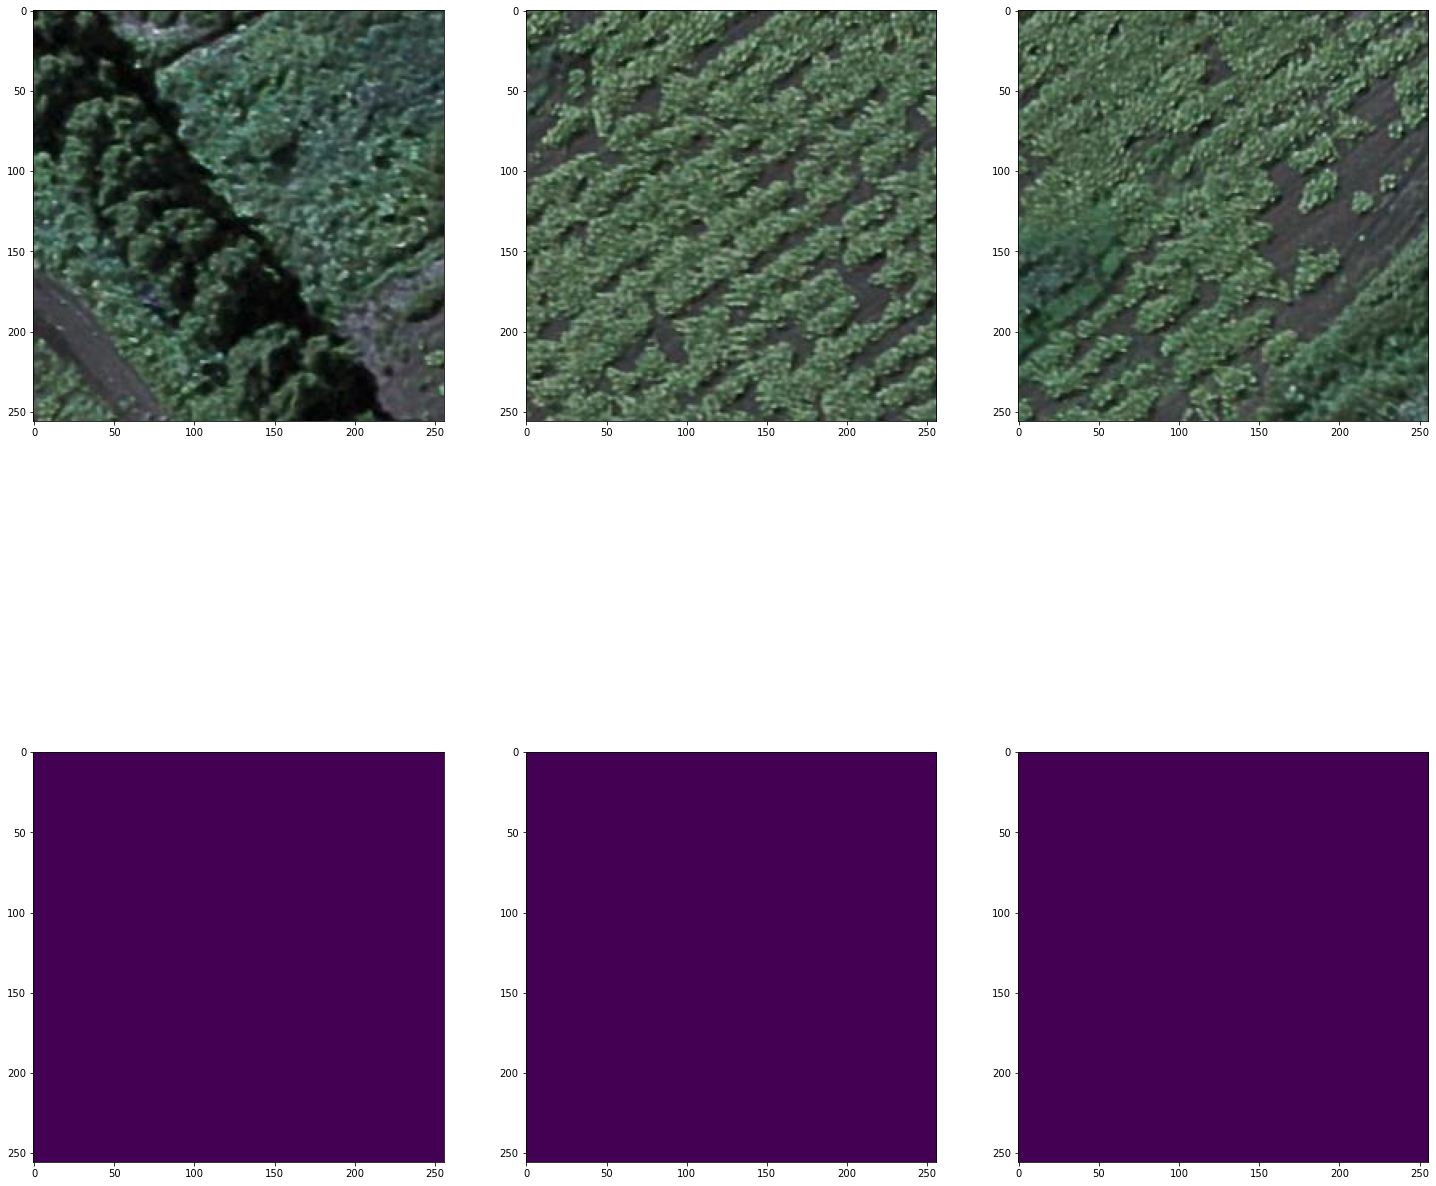

In [23]:
show_images(x, y)

### Splitting data

We can split data into training set and validation set only as we can ad test set

In [24]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_split(x, y, train_rate=0.7)

print("Number of training examples  : {}".format(X_train.shape[0]))
print("Numer of validation examples : {}".format(X_val.shape[0]))
print("Number of test examples      : {}".format(X_test.shape[0]))

Number of training examples  : 840
Numer of validation examples : 180
Number of test examples      : 180


### U-NET

In [25]:
from keras_unet.models import satellite_unet

model_sate = satellite_unet(input_shape=(256, 256, 3))

In [27]:
num_epoch = 100
batch_size = 16
learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model_sate.compile(optimizer=optimizer, loss=['MSE'], metrics=['MSE'])


history = model_sate.fit(X_train, y_train, batch_size=batch_size, epochs=num_epoch,
 validation_data=(X_val, y_val))

Epoch 1/100


2022-08-22 02:05:30.599333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 0.1067 - MSE: 0.1067

2022-08-22 02:06:31.199996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 66s 1s/step - loss: 0.1067 - MSE: 0.1067 - val_loss: 0.0992 - val_MSE: 0.0992
Epoch 2/100
53/53 [==============================] - 57s 1s/step - loss: 0.0909 - MSE: 0.0909 - val_loss: 0.0860 - val_MSE: 0.0860
Epoch 3/100
53/53 [==============================] - 57s 1s/step - loss: 0.0874 - MSE: 0.0874 - val_loss: 0.0841 - val_MSE: 0.0841
Epoch 4/100
53/53 [==============================] - 57s 1s/step - loss: 0.0785 - MSE: 0.0785 - val_loss: 0.0774 - val_MSE: 0.0774
Epoch 5/100
53/53 [==============================] - 57s 1s/step - loss: 0.0699 - MSE: 0.0699 - val_loss: 0.0635 - val_MSE: 0.0635
Epoch 6/100
53/53 [==============================] - 57s 1s/step - loss: 0.0615 - MSE: 0.0615 - val_loss: 0.0801 - val_MSE: 0.0801
Epoch 7/100
53/53 [==============================] - 57s 1s/step - loss: 0.0683 - MSE: 0.0683 - val_loss: 0.0761 - val_MSE: 0.0761
Epoch 8/100
53/53 [==============================] - 57s 1s/step - loss: 0.0604 - MSE: 0.0604 -

53/53 [==============================] - 56s 1s/step - loss: 0.0217 - MSE: 0.0217 - val_loss: 0.0493 - val_MSE: 0.0493
Epoch 64/100
53/53 [==============================] - 56s 1s/step - loss: 0.0187 - MSE: 0.0187 - val_loss: 0.0492 - val_MSE: 0.0492
Epoch 65/100
53/53 [==============================] - 56s 1s/step - loss: 0.0179 - MSE: 0.0179 - val_loss: 0.0532 - val_MSE: 0.0532
Epoch 66/100
53/53 [==============================] - 56s 1s/step - loss: 0.0202 - MSE: 0.0202 - val_loss: 0.0520 - val_MSE: 0.0520
Epoch 67/100
53/53 [==============================] - 56s 1s/step - loss: 0.0248 - MSE: 0.0248 - val_loss: 0.0602 - val_MSE: 0.0602
Epoch 68/100
53/53 [==============================] - 56s 1s/step - loss: 0.0205 - MSE: 0.0205 - val_loss: 0.0551 - val_MSE: 0.0551
Epoch 69/100
53/53 [==============================] - 56s 1s/step - loss: 0.0200 - MSE: 0.0200 - val_loss: 0.0504 - val_MSE: 0.0504
Epoch 70/100
53/53 [==============================] - 56s 1s/step - loss: 0.0181 - MSE: 0

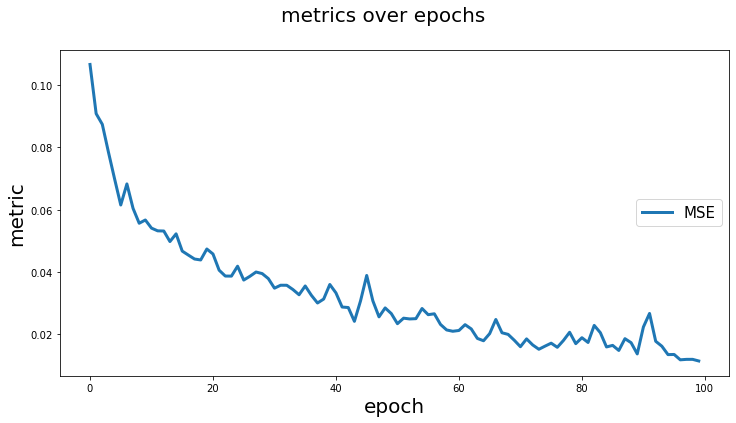

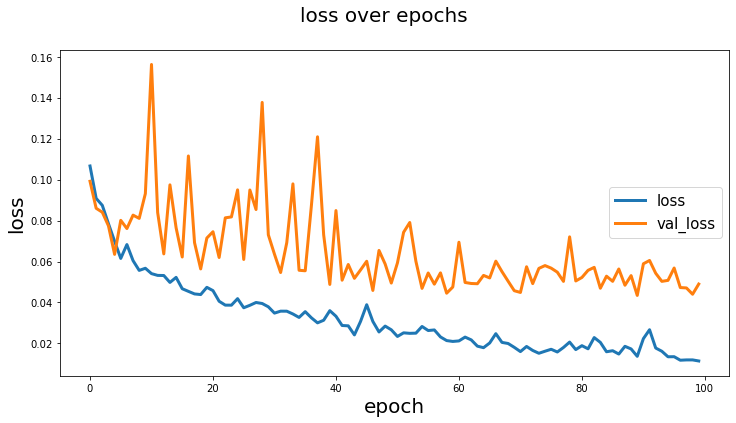

In [28]:
from keras_unet.utils import plot_segm_history
plot_segm_history(
    history, # required - keras training history object
    metrics=['MSE'], # optional - metrics names to plot
    losses=['loss', 'val_loss']) # optional - loss names to plot

In [29]:
model_sate.save('seg_sate')

INFO:tensorflow:Assets written to: seg_sate/assets


INFO:tensorflow:Assets written to: seg_sate/assets


In [16]:
from keras_unet.models import custom_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [17]:
img_size_x = 1024
img_size_y = 1024

num_channels_inp = 3

model = custom_unet(
    input_shape=(img_size_x, img_size_y, num_channels_inp),
    use_batch_norm=False,
    num_classes=1,
    filters=8,
    dropout=0.1,
    activation='tanh',
    output_activation='tanh')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   224         ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 1024, 1024,   0          ['conv2d[0][0]']                 
 out2D)                         8)                                                            

 conv2d_transpose_2 (Conv2DTran  (None, 512, 512, 16  2064       ['conv2d_13[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_2 (Concatenate)    (None, 512, 512, 32  0           ['conv2d_transpose_2[0][0]',     
                                )                                 'conv2d_3[0][0]']               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 512, 512, 16  4624        ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_14[0][0]']              
          

In [18]:
num_epoch = 100
batch_size = 4
learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=['MSE'], metrics=['MSE'])


history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epoch,
 validation_data=(X_val, y_val))

Epoch 1/100


2022-08-21 10:22:09.403396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 0.1249 - MSE: 0.1249

2022-08-21 10:22:27.108147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 19s 915ms/step - loss: 0.1249 - MSE: 0.1249 - val_loss: 0.0649 - val_MSE: 0.0649
Epoch 2/100
17/17 [==============================] - 14s 823ms/step - loss: 0.0819 - MSE: 0.0819 - val_loss: 0.0662 - val_MSE: 0.0662
Epoch 3/100
17/17 [==============================] - 14s 825ms/step - loss: 0.0705 - MSE: 0.0705 - val_loss: 0.0619 - val_MSE: 0.0619
Epoch 4/100
17/17 [==============================] - 14s 820ms/step - loss: 0.0738 - MSE: 0.0738 - val_loss: 0.0719 - val_MSE: 0.0719
Epoch 5/100
17/17 [==============================] - 14s 817ms/step - loss: 0.0729 - MSE: 0.0729 - val_loss: 0.0606 - val_MSE: 0.0606
Epoch 6/100
17/17 [==============================] - 14s 817ms/step - loss: 0.0691 - MSE: 0.0691 - val_loss: 0.0567 - val_MSE: 0.0567
Epoch 7/100
17/17 [==============================] - 14s 823ms/step - loss: 0.0638 - MSE: 0.0638 - val_loss: 0.0511 - val_MSE: 0.0511
Epoch 8/100
17/17 [==============================] - 14s 817ms/step - loss

Epoch 62/100
17/17 [==============================] - 14s 836ms/step - loss: 0.0508 - MSE: 0.0508 - val_loss: 0.0302 - val_MSE: 0.0302
Epoch 63/100
17/17 [==============================] - 15s 862ms/step - loss: 0.0549 - MSE: 0.0549 - val_loss: 0.0374 - val_MSE: 0.0374
Epoch 64/100
17/17 [==============================] - 15s 863ms/step - loss: 0.0571 - MSE: 0.0571 - val_loss: 0.0400 - val_MSE: 0.0400
Epoch 65/100
17/17 [==============================] - 15s 855ms/step - loss: 0.0519 - MSE: 0.0519 - val_loss: 0.0593 - val_MSE: 0.0593
Epoch 66/100
17/17 [==============================] - 14s 847ms/step - loss: 0.0515 - MSE: 0.0515 - val_loss: 0.0304 - val_MSE: 0.0304
Epoch 67/100
17/17 [==============================] - 14s 845ms/step - loss: 0.0477 - MSE: 0.0477 - val_loss: 0.0415 - val_MSE: 0.0415
Epoch 68/100
17/17 [==============================] - 14s 846ms/step - loss: 0.0490 - MSE: 0.0490 - val_loss: 0.0545 - val_MSE: 0.0545
Epoch 69/100
17/17 [==============================] - 1

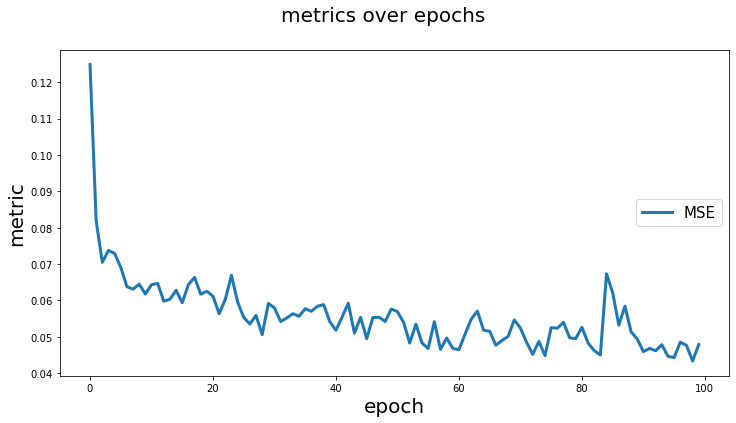

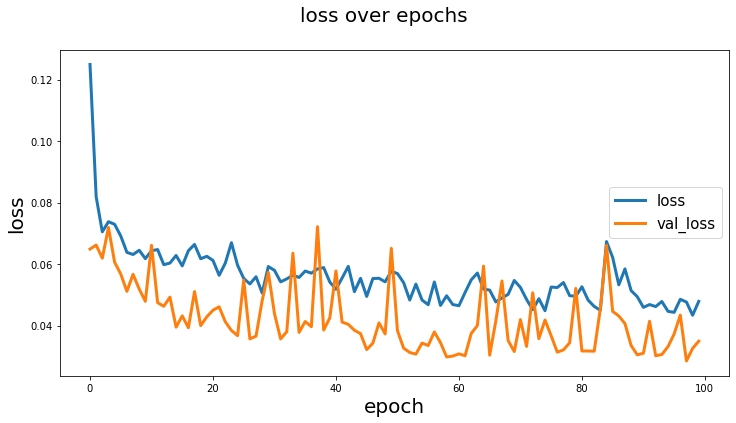

In [19]:
from keras_unet.utils import plot_segm_history
plot_segm_history(
    history, # required - keras training history object
    metrics=['MSE'], # optional - metrics names to plot
    losses=['loss', 'val_loss']) # optional - loss names to plot

In [57]:
model1= tf.keras.models.load_model('seg0')

In [30]:
pre1=model_sate.predict(X_test)

2022-08-22 11:03:08.102556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 4s 570ms/step


In [31]:
pre1.shape

(180, 256, 256, 1)

In [32]:
predict = model_sate.predict(X_test)

6/6 [==============================] - 3s 533ms/step


In [34]:
predict

array([[[[4.11964394e-02],
         [2.65335906e-02],
         [1.34180449e-02],
         ...,
         [1.64231416e-02],
         [2.11114641e-02],
         [3.87736298e-02]],

        [[2.61465404e-02],
         [1.91850308e-02],
         [1.04579348e-02],
         ...,
         [8.05320870e-03],
         [1.39552150e-02],
         [2.46579144e-02]],

        [[1.81194935e-02],
         [1.40176835e-02],
         [7.52617605e-03],
         ...,
         [7.64609128e-03],
         [9.93462745e-03],
         [1.63223576e-02]],

        ...,

        [[7.25472122e-02],
         [1.05674572e-01],
         [1.06365688e-01],
         ...,
         [7.32540607e-01],
         [6.69817388e-01],
         [7.59850383e-01]],

        [[9.24376920e-02],
         [9.68227386e-02],
         [1.19503722e-01],
         ...,
         [7.96534359e-01],
         [7.56673098e-01],
         [6.94543302e-01]],

        [[1.03904568e-01],
         [1.08273402e-01],
         [1.25223577e-01],
         ...,
 

In [27]:
predict.shape

(15, 1024, 1024, 1)

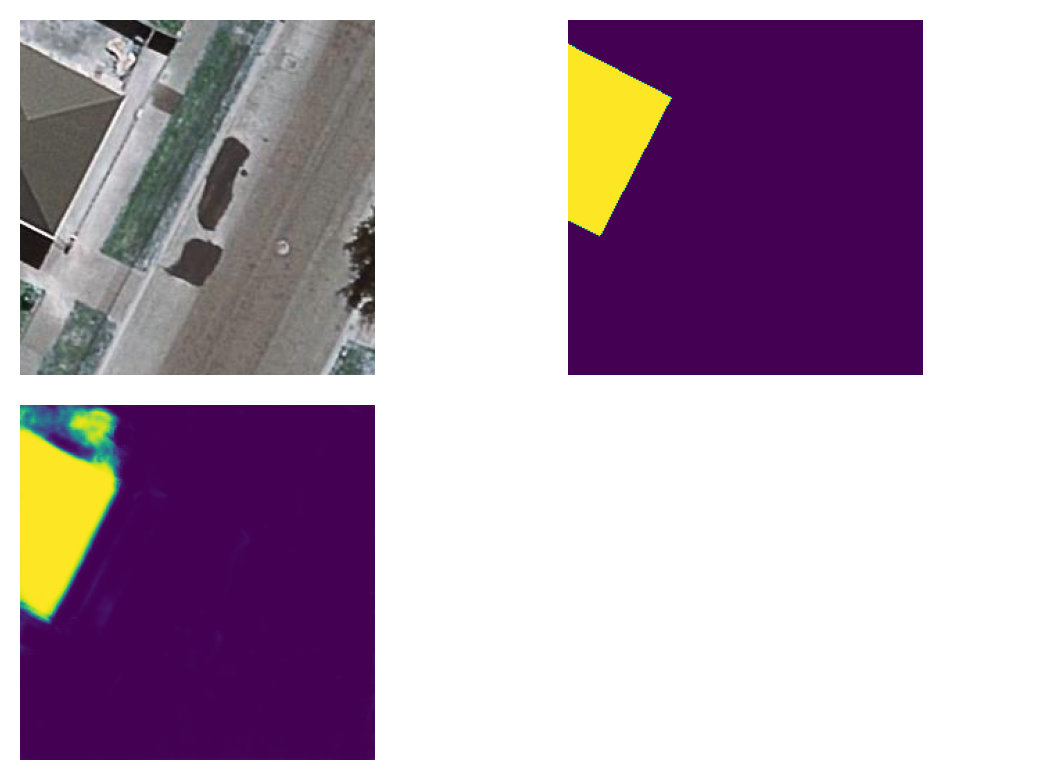

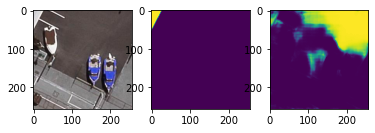

In [33]:
fig, ax = plt.subplots(2,2, dpi=200)
ax[0][0].imshow(X_test[13])
ax[0][0].set_axis_off()
ax[0][1].imshow(y_test[13])
ax[0][1].set_axis_off()
ax[1][0].imshow(predict[13])
ax[1][0].set_axis_off()
ax[1][1].set_axis_off()
plt.tight_layout()
# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])


fig, ax = plt.subplots(1,3)
ax[0].imshow(X_test[1])
ax[1].imshow(y_test[1])
ax[2].imshow(predict[1])

In [106]:
y_mask

array([[[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        ...,

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]],


       [[[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [Fa

In [107]:
y_mask = predict > 0.5
y_true = y_test >0.5

/var/folders/2r/2j6qyrbj7k74yckxjs8vz1zm0000gn/T/ipykernel_13196/430085503.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3)


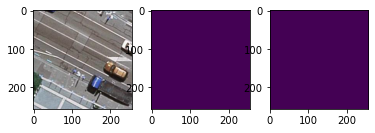

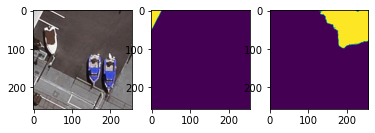

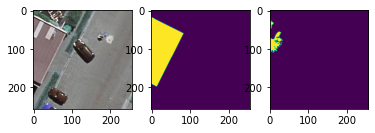

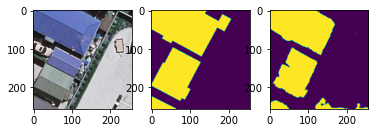

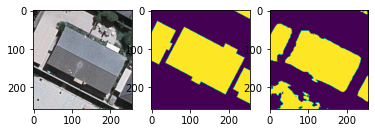

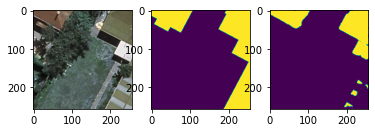

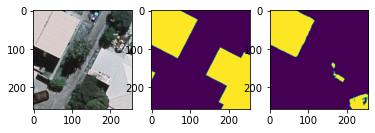

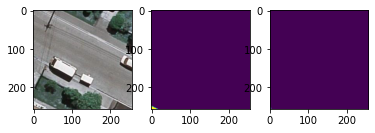

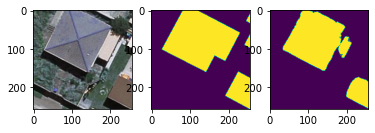

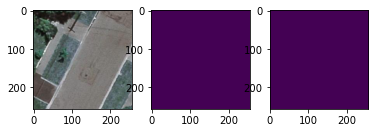

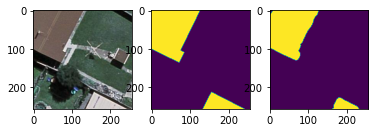

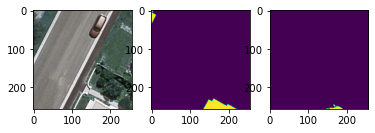

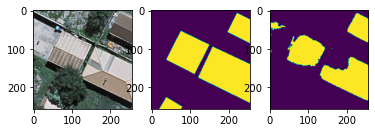

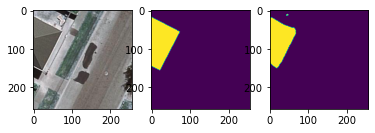

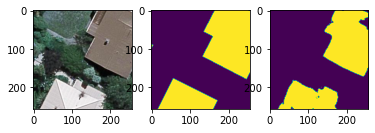

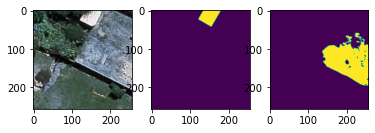

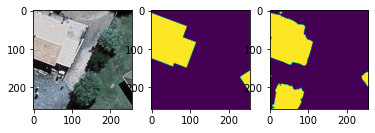

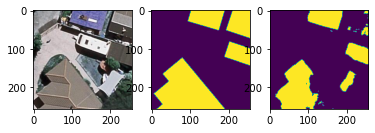

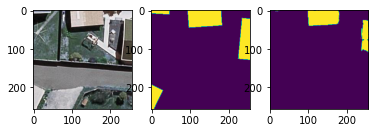

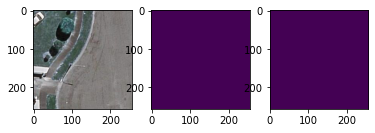

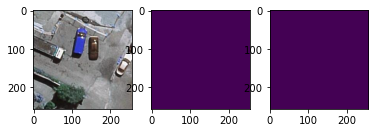

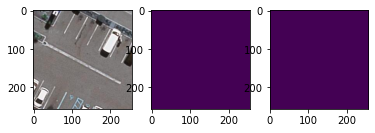

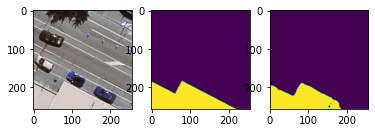

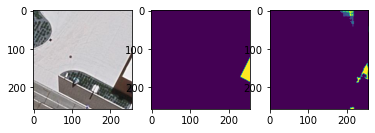

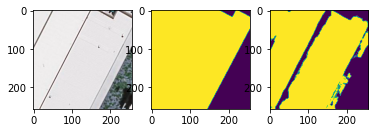

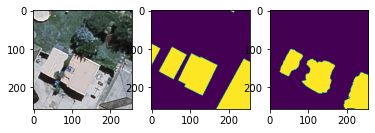

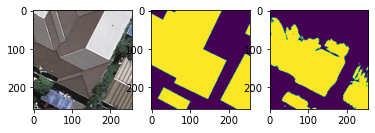

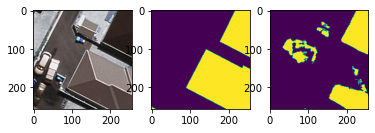

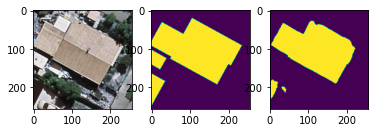

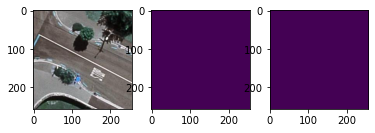

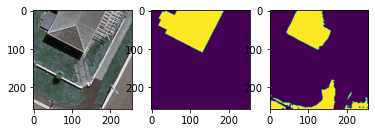

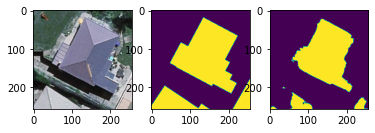

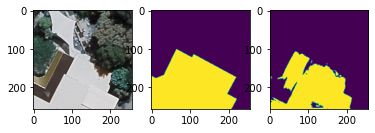

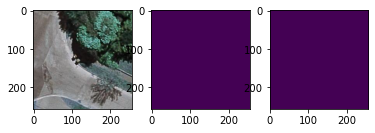

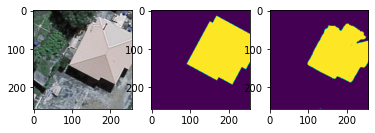

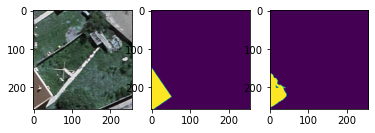

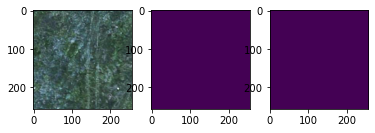

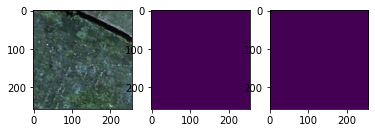

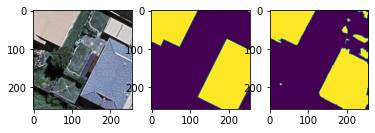

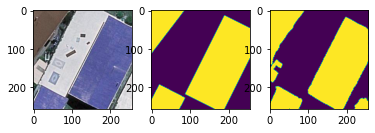

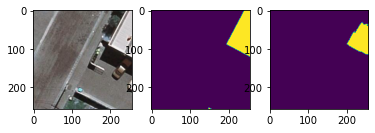

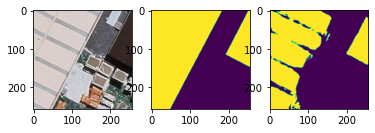

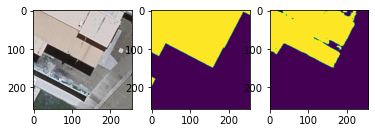

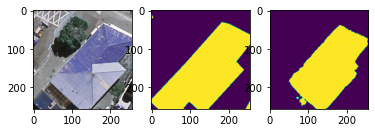

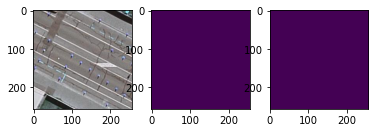

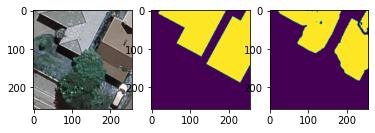

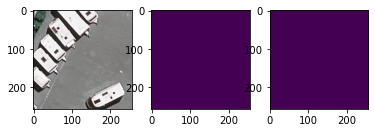

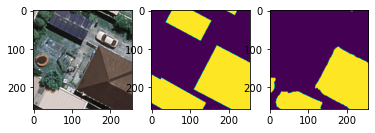

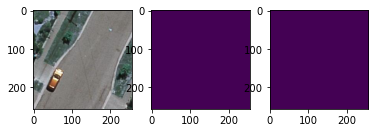

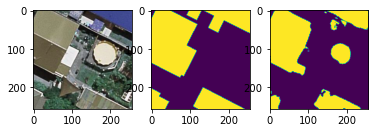

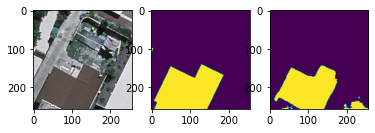

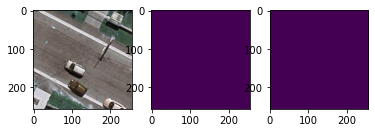

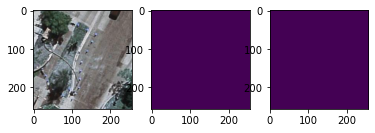

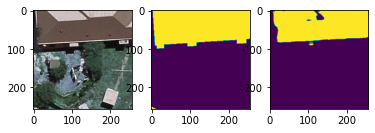

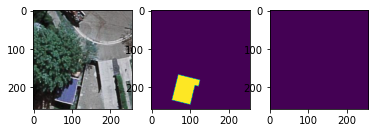

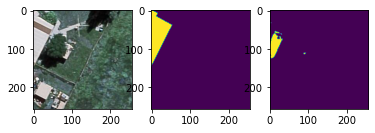

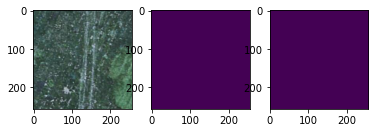

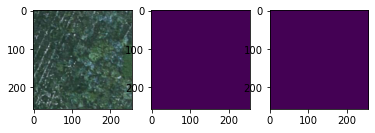

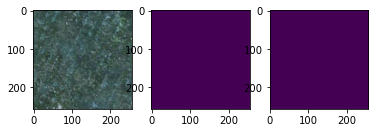

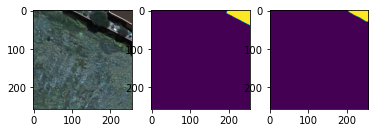

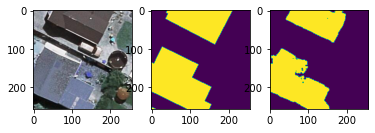

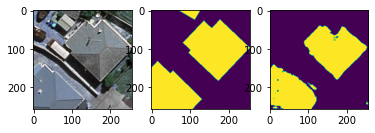

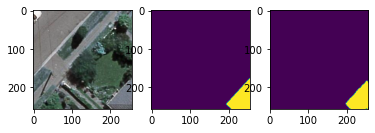

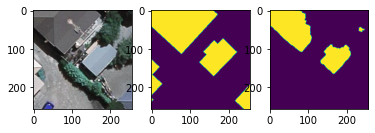

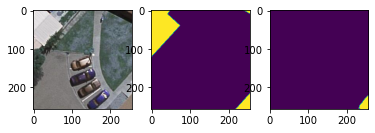

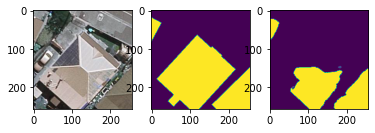

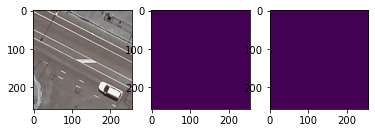

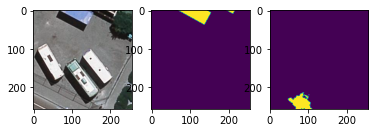

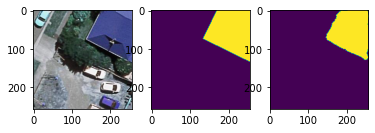

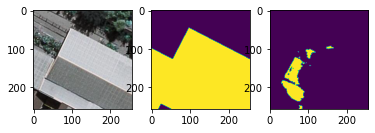

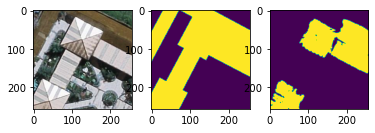

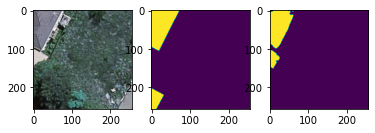

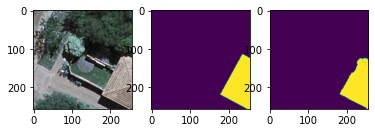

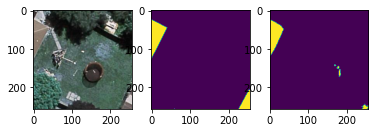

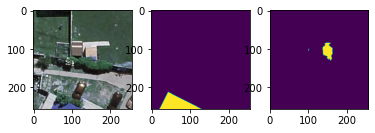

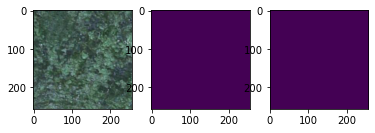

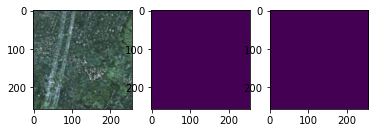

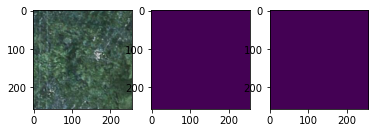

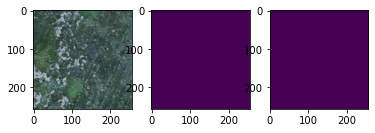

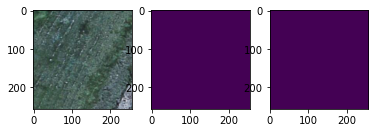

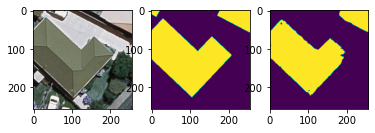

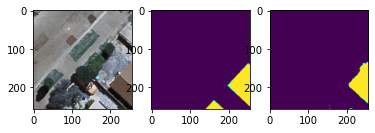

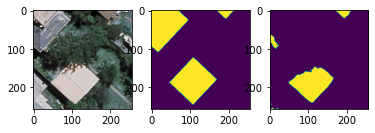

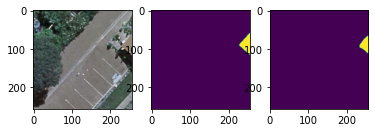

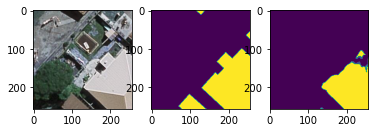

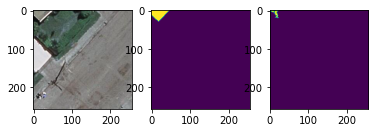

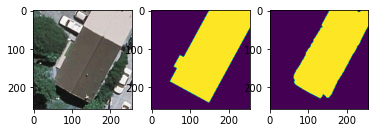

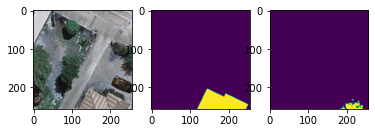

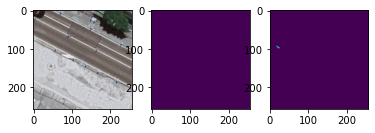

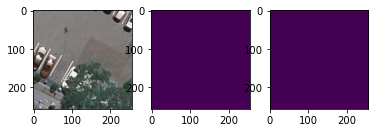

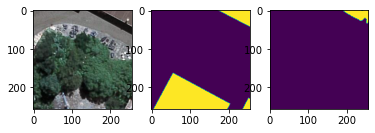

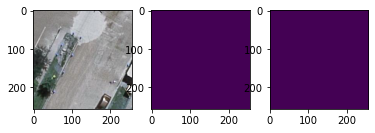

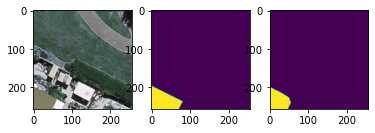

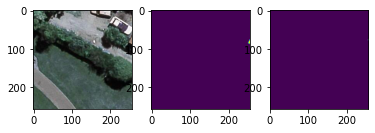

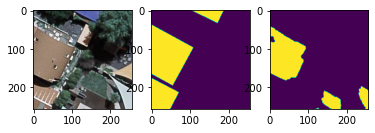

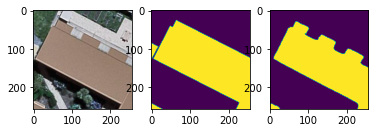

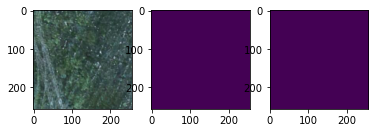

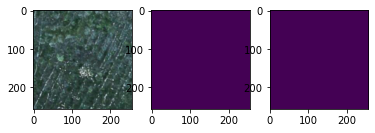

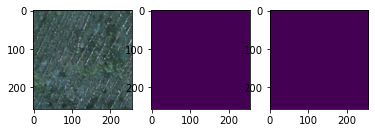

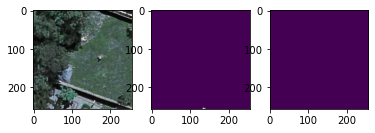

In [46]:
for i in range (0, 100):
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(X_test[i])
    ax[1].imshow(y_test[i])
    ax[2].imshow(y_mask[i])

In [7]:
model_sate = tf.keras.models.load_model('seg_sate')

In [42]:
original,original_mask = read_data('ssa','test','test_label')

/Users/yulin/miniconda/envs/env02/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
original = original/255

In [44]:
pre_origin = model_sate.predict(original)

4/4 [==============================] - 2s 606ms/step


In [18]:
low_res,low_res_label = read_data('ssa','test_low_res','label_low_res')

In [27]:
low_res = low_res/255

In [9]:
sr, label = read_data('ssa','test_enhanced','test_label')

/Users/yulin/miniconda/envs/env02/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
sr = sr/255

In [29]:
pre_enhanced = model_sate.predict(sr)

2022-08-22 20:47:55.136640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 618ms/step


In [30]:
pre_low_res  = model_sate.predict(low_res)

4/4 [==============================] - 2s 513ms/step


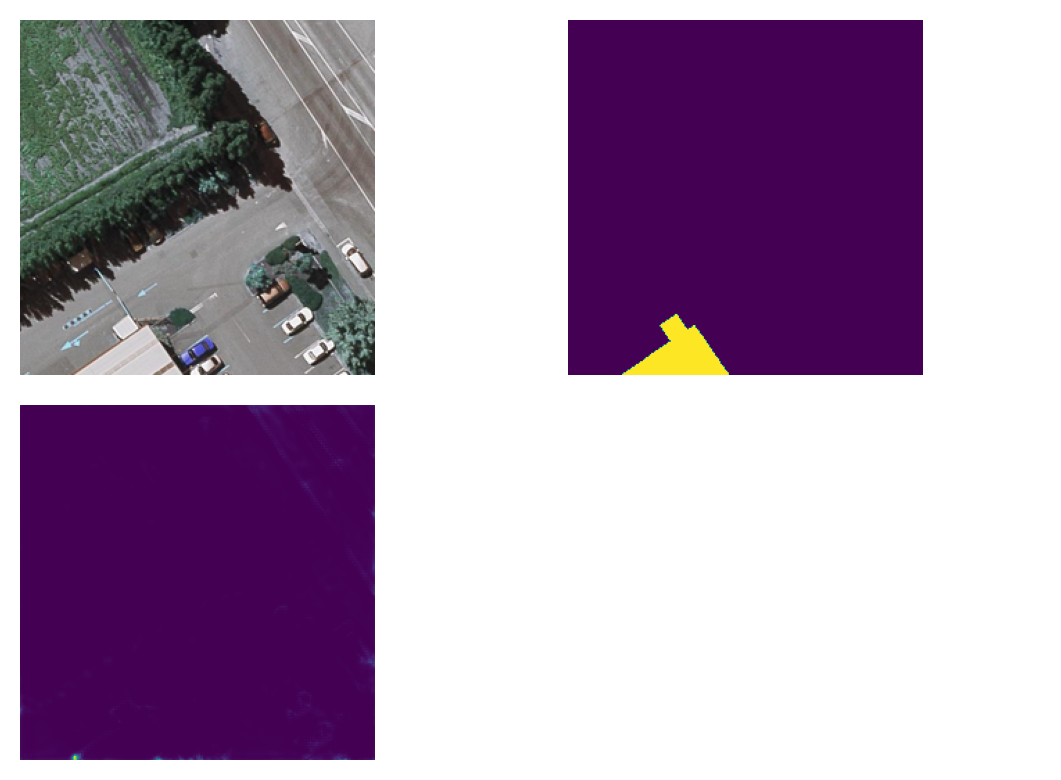

In [31]:
fig, ax = plt.subplots(2,2, dpi=200)
ax[0][0].imshow(low_res[13])
ax[0][0].set_axis_off()
ax[0][1].imshow(low_res_label[13])
ax[0][1].set_axis_off()
ax[1][0].imshow(pre_low_res[13])
ax[1][0].set_axis_off()
ax[1][1].set_axis_off()
plt.tight_layout()

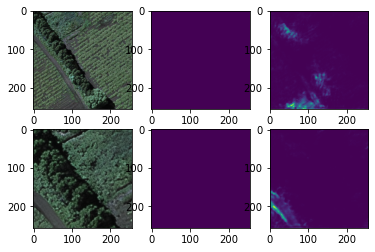

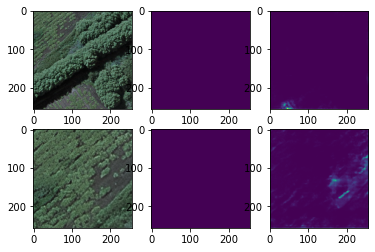

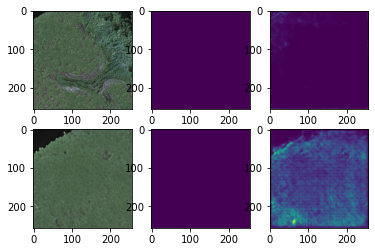

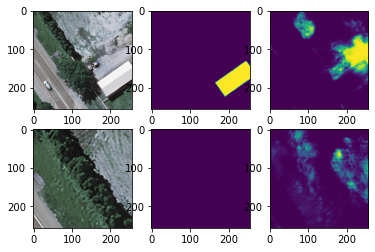

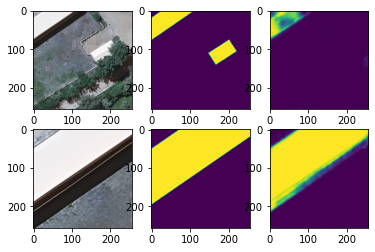

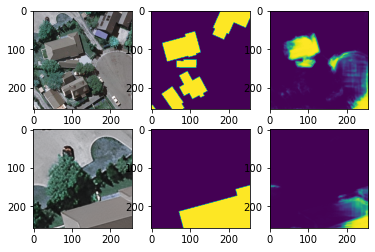

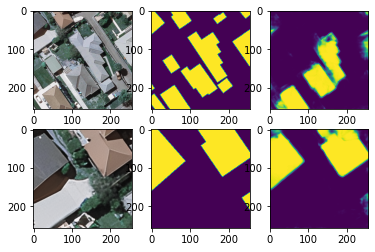

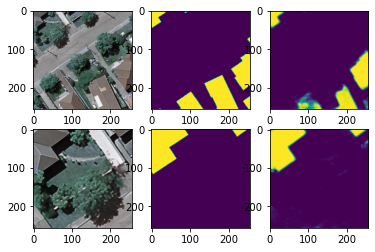

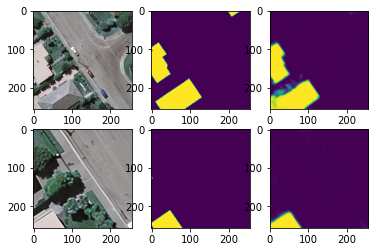

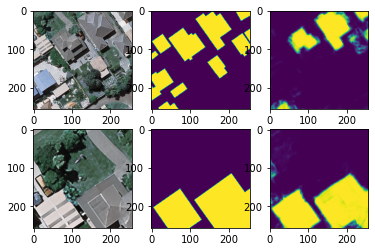

In [32]:
for i in range (0, 10):
    fig, ax = plt.subplots(2,3)
    ax[0,0].imshow(low_res[i])
    ax[0,1].imshow(low_res_label[i])
    ax[0,2].imshow(pre_low_res[i])
    ax[1,0].imshow(sr[i])
    ax[1,1].imshow(label[i])
    ax[1,2].imshow(pre_enhanced[i])

In [33]:
def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background
def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn
def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred) for truth, pred in zip(truths, preds)]
    
    print(ious[0].shape)

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

In [ ]:
iou_map(y_m,pre_e_t,verbose=1)

In [36]:
label_t = label > 0.5
pre_e_t = pre_enhanced > 0.5

In [47]:
compute_iou(label_t, pre_e_t)

array([[0.88200575]])

In [37]:
iou_map(label_t,pre_e_t,verbose=1)

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


(0, 0)
Thresh	TP	FP	FN	Prec.
0.500	69	16	4	0.775
0.550	68	17	5	0.756
0.600	67	18	6	0.736
0.650	66	19	7	0.717
0.700	63	22	10	0.663
0.750	59	26	14	0.596
0.800	57	28	16	0.564
0.850	49	36	24	0.450
0.900	36	49	37	0.295
0.950	12	73	61	0.082
AP	-	-	-	0.563


0.5634780453822228

In [38]:
pre_l_t = pre_low_res > 0.5
label_l_t = low_res_label >0.5

In [48]:
compute_iou(label_l_t, pre_l_t)

array([[0.59920305]])

In [39]:
iou_map(label_l_t,pre_l_t,verbose=1)

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


(0, 0)
Thresh	TP	FP	FN	Prec.
0.500	61	30	32	0.496
0.550	54	37	39	0.415
0.600	47	44	46	0.343
0.650	39	52	54	0.269
0.700	31	60	62	0.203
0.750	21	70	72	0.129
0.800	11	80	82	0.064
0.850	4	87	89	0.022
0.900	2	89	91	0.011
0.950	1	90	92	0.005
AP	-	-	-	0.196


0.19570590494338852

In [45]:
original_t = pre_origin > 0.5

In [49]:
compute_iou(label_t, original_t)

array([[0.90161627]])

In [46]:
iou_map(label_t,original_t,verbose=1)

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


(0, 0)
Thresh	TP	FP	FN	Prec.
0.500	69	10	4	0.831
0.550	69	10	4	0.831
0.600	68	11	5	0.810
0.650	68	11	5	0.810
0.700	68	11	5	0.810
0.750	65	14	8	0.747
0.800	63	16	10	0.708
0.850	57	22	16	0.600
0.900	43	36	30	0.394
0.950	15	64	58	0.109
AP	-	-	-	0.665


0.6650198100240929

In [41]:
model_sate.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_48 (BatchN  (None, 256, 256, 64  256        ['conv2d_45[0][0]']              
 ormalization)                  )                                                           

                                                                                                  
 conv2d_57 (Conv2D)             (None, 16, 16, 64)   36928       ['batch_normalization_59[0][0]'] 
                                                                                                  
 batch_normalization_60 (BatchN  (None, 16, 16, 64)  256         ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_58 (Conv2D)             (None, 16, 16, 64)   36928       ['batch_normalization_60[0][0]'] 
                                                                                                  
 batch_normalization_61 (BatchN  (None, 16, 16, 64)  256         ['conv2d_58[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_73 (BatchN  (None, 64, 64, 64)  256         ['conv2d_67[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_transpose_9 (Conv2DTran  (None, 128, 128, 64  36928      ['batch_normalization_73[0][0]'] 
 spose)                         )                                                                 
                                                                                                  
 concatenate_9 (Concatenate)    (None, 128, 128, 12  0           ['conv2d_transpose_9[0][0]',     
                                8)                                'conv2d_49[0][0]']              
                                                                                                  
 batch_normalization_74 (BatchN  (None, 128, 128, 12  512        ['concatenate_9[0][0]']          
 ormalizat